# Практическая работа 2. Парсинг HTML и консолидация данных

**Студент:** *Нургалеева Гузель*

**Вариант:** №16

**В связи с тем, что запрос к сайту dns-shop.ru выдавал ошибку 401, что, возможно, связано с правами доступа к сайту (*также пробовала спарсить mvideo, technopark, но там была аналогичная ситуация*), анализировала данные с сайта GeekBrains.ru. Это - образовательная платформа, на которой представлены курсы в том числе по аналитике и программированию.**

**Бизнес-кейс:** анализ курсов, предоставляемых GeekBrains, и скрейпинг статей, размещенных на сайте

**Источник:** заменен на: Каталог курсов на gb.ru (3-5 страниц)

**Задача:** собрать данные о названии курсов, предоставялемых скидках на курс, продолжительности обучения. По окончании каких курсов есть услуга по помощи в трудоуствройстве, в описании каких курсов есть информация о потенциальной зарплате и какой разброс зарплат. По собранным статьям определить самые просматриваемые, какие статьи входили в топ-5 в разные годы публикации

### Установка необходимых библиотек

In [ ]:
!pip install -q requests beautifulsoup4 pandas matplotlib seaborn

In [ ]:
import warnings
warnings.filterwarnings ('ignore')

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re



### Попытка спарсить данные с dns-shop.ru. Обновление парсера для сбора данных видеокартах

<font color = "red" size = 4>Запрос к dns-shop.ru выдавал ошибку 401, возможно, для срейпинга сайта нужен ключ</font>
<br> Запрос и ответ на него приведены ниже

In [ ]:
# --- Настройки парсера ---
BASE_URL = 'https://www.dns-shop.ru/catalog/17a89aab16404e77/videokarty/?f[9y]=dd'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
PAGES_TO_PARSE = 5

data = []

print(f"Начинаем парсинг {PAGES_TO_PARSE} страниц...")

# Цикл для прохода по страницам пагинации
for page in range(1, PAGES_TO_PARSE + 1):
    url = f"{BASE_URL}&p={page}"
    print(f"Обрабатываем страницу: {url}")

    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status() # Проверка на ошибки HTTP (4xx или 5xx)

        soup = BeautifulSoup(response.text, 'html.parser')

        # Находим все карточки вакансий на странице
        # (Класс 'vacancy-preview-card__main' был найден через инструменты разработчика)
        product_cards = soup.find_all('div', class_='catalog-products view-simple')

        if not product_cards:
            print("Не найдено карточек вакансий на странице. Возможно, изменилась структура сайта.")
            break

        for card in product_cards:
            # Используем try-except для устойчивости парсера
            try:
                name = card.find('span', class_='catalog-product__name ui-link ui-link_black').text.strip()
            except AttributeError:
                name = 'Не указано'


            try:
                company = card.find('span', class_='catalog-product__name ui-link ui-link_black').text.strip()
            except AttributeError:
                company = 'Не указано'

            try:
                # Опыт работы находится в блоке с иконкой портфеля
                price = card.find('div', class_='product-buy__price').text.strip()
            except AttributeError:
                price = 'Цена не указана'

            data.append({
                'name': name,
                'company': company,
                'price': price
            })

    except requests.RequestException as e:
        print(f"Ошибка при запросе к странице {page}: {e}")
        break

    # Вежливая задержка между запросами
    time.sleep(1)

print(f"\nПарсинг завершен. Собрано {len(data)} видеокарт.")

Начинаем парсинг 5 страниц...
Обрабатываем страницу: https://www.dns-shop.ru/catalog/17a89aab16404e77/videokarty/?f[9y]=dd&p=1
Ошибка при запросе к странице 1: 401 Client Error: Unauthorized for url: https://www.dns-shop.ru/catalog/17a89aab16404e77/videokarty/?f%5B9y%5D=dd&p=1

Парсинг завершен. Собрано 0 видеокарт.


### Шаг 1. Сбор данных


#### Опубликованные статьи

In [ ]:
# --- Настройки парсера ---
BASE_URL = 'https://gb.ru/posts'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
PAGES_TO_PARSE = 5

data_title = []
data_date = []
data_counter = []

print(f"Начинаем парсинг {PAGES_TO_PARSE} страниц...")

# Цикл для прохода по страницам пагинации
for page in range(1, PAGES_TO_PARSE + 1):
    url = f"{BASE_URL}?page={page}"
    print(f"Обрабатываем страницу: {url}")

    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status() # Проверка на ошибки HTTP (4xx или 5xx)

        soup = BeautifulSoup(response.text, 'html.parser')

        # Находим все карточки вакансий на странице
        # (Класс 'vacancy-preview-card__main' был найден через инструменты разработчика)
        title_cards = soup.find_all('div', class_='text-left v-padder m-r m-l')
        counter_cards = soup.find_all('div', class_= 'icon-counter post-counter') #'text-muted post-counters-wrapper')

        if not title_cards:
            print("Не найдено карточек вакансий на странице. Возможно, изменилась структура сайта.")
            break

        for card in title_cards:
            # Используем try-except для устойчивости парсера
            try:
                name = card.find('a', class_='post-item__title h3 search_text').text.strip()
            except AttributeError:
                name = 'Не указано'

            data_title.append(
                name
            )
            try:
                date = card.find('div', class_='small m-t-xs').text.strip()
            except AttributeError:
                date = 'Не указано'

            data_date.append(
                date
            )

        for card in counter_cards:
            try:
                counts = card.find('span').text.strip() #, class_='svg-icon icon-views-mini '
            except AttributeError:
                counts = 'Не указано'

            data_counter.append(
                counts
            )

    except requests.RequestException as e:
        print(f"Ошибка при запросе к странице {page}: {e}")
        break

    # Вежливая задержка между запросами
    time.sleep(1)

print(f"\nПарсинг завершен. Собрано {len(data_title)} статей.")

Начинаем парсинг 5 страниц...
Обрабатываем страницу: https://gb.ru/posts?page=1
Обрабатываем страницу: https://gb.ru/posts?page=2
Обрабатываем страницу: https://gb.ru/posts?page=3
Обрабатываем страницу: https://gb.ru/posts?page=4
Обрабатываем страницу: https://gb.ru/posts?page=5

Парсинг завершен. Собрано 150 статей.


In [ ]:
data_views = []
data_comments = []

for i in range(len(data_counter)):
    if i == 0:
        data_views.append(data_counter[i])
    elif i%2==0:
        data_views.append(data_counter[i])
    else:
        data_comments.append(data_counter[i])


data_posts = []

for i in range(len(data_title)):
    data_posts.append({
        "name": data_title[i],
        "views": data_views[i],
        "comments": data_comments[i],
        "date": data_date[i]
        })

In [ ]:
data_posts[:10]

[{'name': 'Как в 13 лет заработать на 3D-моделировании',
  'views': '81271',
  'comments': '3',
  'date': '22 декабря 2023'},
 {'name': 'Как совмещать работу, семью и обучение ИТ',
  'views': '80224',
  'comments': '6',
  'date': '06 декабря 2023'},
 {'name': 'Закончить GeekSchool, чтобы помогать маме с бизнесом',
  'views': '80409',
  'comments': '5',
  'date': '24 ноября 2023'},
 {'name': 'Маркетолог Gucci, курьер, аналитик ― карьера нашего студента',
  'views': '78565',
  'comments': '3',
  'date': '24 ноября 2023'},
 {'name': 'Как выступления помогают профессиональному развитию',
  'views': '82540',
  'comments': '3',
  'date': '17 ноября 2023'},
 {'name': 'Как нейросети помогут в работе руководителю проектов',
  'views': '83874',
  'comments': '4',
  'date': '01 ноября 2023'},
 {'name': 'Как создать и продать свой NFT',
  'views': '105385',
  'comments': '3',
  'date': '10 октября 2023'},
 {'name': 'Как из маркетинга уйти в продакт-менеджеры',
  'views': '1089',
  'comments': '0',

#### Предоставляемые курсы

In [ ]:
# --- Настройки парсера ---
BASE_URL = 'https://gb.ru/courses/all'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

#PAGES_TO_PARSE = 5

cources_title = []
cources_description = []
cources_duration = []
cources_discount = []

print(f"Начинаем парсинг...")

# Цикл для прохода по страницам пагинации
for page in range(1):
    url = f"{BASE_URL}" #?page={page}"
    print(f"Обрабатываем страницу: {url}")

    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status() # Проверка на ошибки HTTP (4xx или 5xx)

        soup = BeautifulSoup(response.text, 'html.parser')

        # Находим все карточки вакансий на странице
        cources_name = soup.find_all('a', class_='card_full_link')
        cources_body = soup.find_all('div', class_='direction-card__body')
        cources_info_duration = soup.find_all('div', class_= 'direction-card__info-text ui-text-body--6 --margin-bot')
        cources_info_discount = soup.find_all('div', class_= 'direction-card__info')


        if not cources_body:
            print("Не найдено карточек вакансий на странице. Возможно, изменилась структура сайта.")
            break

        for card in cources_name:
            # Используем try-except для устойчивости парсера
            try:
                title = card.find('span', class_= 'direction-card__title-text ui-text-body--1 ui-text--medium').text.strip()
            except AttributeError:
                title = 'Не указано'

            cources_title.append(
                title
            )
        for card in cources_body:
            try:
                description = card.find('div', class_= 'direction-card__text') .text.strip()
            except AttributeError:
                description = 'Не указано'

            cources_description.append(
                description
            )

        for card in cources_info_duration:
            try:
                duration = card.find('span', class_= 'ui-text--medium').text.strip()
            except AttributeError:
                duration = 'Не указано'

            cources_duration.append(
                duration
            )
        for card in cources_info_discount:
            try:
                discount = card.find('div', class_= 'direction-card__info-label ui-text-heading--5 ui-text--medium gb-landings-product-discount').text.strip()
            except AttributeError:
                discount = 'Не указано'

            cources_discount.append(
                discount
            )

    except requests.RequestException as e:
        print(f"Ошибка при запросе к странице {page}: {e}")
        break

    # Вежливая задержка между запросами
    time.sleep(1)

print(f"\nПарсинг завершен. Собрано {len(cources_title)} курсов.")

Начинаем парсинг...
Обрабатываем страницу: https://gb.ru/courses/all

Парсинг завершен. Собрано 69 курсов.


In [ ]:
data_cources= []

for i in range(len(cources_title)):
    data_cources.append({
        "title": cources_title[i],
        "description": cources_description[i],
        "duration": cources_duration[i],
        "discount": cources_discount[i]
        })
data_cources[:7]

[{'title': 'Разработчик c\xa0AI',
  'description': 'Наш главный курс, чтобы получить профессию и начать карьеру в разработке',
  'duration': '12 месяцев',
  'discount': '-45%'},
 {'title': 'Дизайнер',
  'description': 'Наш главный курс, чтобы получить профессию и начать карьеру в дизайне',
  'duration': '13 месяцев',
  'discount': '-45%'},
 {'title': 'Маркетолог',
  'description': 'Наш главный курс, чтобы получить профессию и начать карьеру в маркетинге',
  'duration': '13 месяцев',
  'discount': '-45%'},
 {'title': 'Аналитик',
  'description': 'Наш главный курс, чтобы получить профессию и начать карьеру в аналитике',
  'duration': '13 месяцев',
  'discount': '-45%'},
 {'title': 'Тестировщик c\xa0AI',
  'description': 'Наш главный курс, чтобы получить профессию и начать карьеру в тестировании',
  'duration': '12 месяцев',
  'discount': '-45%'},
 {'title': 'Python-разработчик c\xa0AI',
  'description': '• Средняя зарплата: 192 000 ₽/мес.• Помощь с трудоустройством: да',
  'duration': '1

In [ ]:
cources_df = pd.DataFrame(data_cources)
cources_df.head()

,title,description,duration,discount
0,Разработчик c AI,"Наш главный курс, чтобы получить профессию и н...",12 месяцев,-45%
1,Дизайнер,"Наш главный курс, чтобы получить профессию и н...",13 месяцев,-45%
2,Маркетолог,"Наш главный курс, чтобы получить профессию и н...",13 месяцев,-45%
3,Аналитик,"Наш главный курс, чтобы получить профессию и н...",13 месяцев,-45%
4,Тестировщик c AI,"Наш главный курс, чтобы получить профессию и н...",12 месяцев,-45%


### Шаг 2. Очистка данных. Использование регулярных выражений для очистки данных от спецсимоволов и извлечения данных о зарплате, скидке.

#### Предоставляемые курсы

In [ ]:
# очистка данных в столбце duartion, чтобы можно было посмотреть, оценить курсы по продолжительности
cources_df.loc[:,'duration'] = [re.sub('\s[\u0401\u0451\u0410-\u044f]+', '', i) for i in cources_df['duration']] # убираем при помощи regex все символы в кириллице и пробелы
cources_df.loc[:,'discount'] = cources_df['discount'].replace(r'\%', '', regex = True)  # убираем знак %
cources_df.loc[:,'discount'] = cources_df['discount'].replace(r'[+-]', '', regex = True) # убираем символы + и -

# также очистим от лишних символов названия курсов
cources_df.loc[:,'title'] = cources_df['title'].replace(r'\xa0', ' ', regex = True) # в наименовании встречаются служебные символы, убираем их
cources_df.loc[:,'title'] = cources_df['title'].replace(r'\xad', '-', regex = True) # в наименовании встречаются служебные символы, убираем их

# также очистим от лишних символов описание курсов
cources_df['description'] = cources_df['description'].replace(r'\xa0', ' ', regex = True) # в описании встречаются служебные символы, убираем их

# выведем в отдельный столбец признак 'Помощь с трудоустройством'
cources_df.loc[cources_df['description'].str.contains("Помощь с трудоустройством: да"), 'job search help'] = 1

# выведем в отдельный столбец данные о потенциальной зарплате

cources_df['potential_salary'] = [re.findall(r'\d{5,6}', i) for i in [re.sub('\s+', '', i) for i in cources_df['description']]] # при помощи regex ищем 5-6 идущих подряд чисел (например,250000).
                                                          # Идущих пожряд, т.к. ищем в строке из которой убрали все пробелы [re.sub('\s+', '', i) for i in cources_df['description']]

# преобразование в число кодом ниже, т.к. код выше дает список строк
for i in range(len(cources_df)):
      if len(cources_df['potential_salary'][i]) == 0:
          cources_df['potential_salary'][i] = int(0)
      else:
          cources_df['potential_salary'][i] = int(cources_df['potential_salary'][i][0])


In [ ]:
# преобразуем типы данных
to_numbers = ['duration', 'discount', 'potential_salary']
for col in to_numbers:
    cources_df[col] = cources_df[col].astype('int32')


In [ ]:
cources_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             69 non-null     object 
 1   description       69 non-null     object 
 2   duration          69 non-null     int32  
 3   discount          69 non-null     int32  
 4   job search help   36 non-null     float64
 5   potential_salary  69 non-null     int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 2.6+ KB


In [ ]:
cources_df.describe()

,duration,discount,potential_salary,job search help
count,69.000000,69.000000,69.000000,36.0
mean,9.289855,44.884058,81028.985507,1.0
std,3.172035,3.349874,76060.535298,0.0
min,2.000000,32.000000,0.000000,1.0
25%,8.000000,45.000000,0.000000,1.0
50%,9.000000,45.000000,90000.000000,1.0
75%,12.000000,45.000000,150000.000000,1.0
max,15.000000,50.000000,250000.000000,1.0


#### Опубликованные статьи

In [ ]:
posts_df = pd.DataFrame(data_posts)
posts_df.head()

,name,views,comments,date
0,Как в 13 лет заработать на 3D-моделировании,81271,3,22 декабря 2023
1,"Как совмещать работу, семью и обучение ИТ",80224,6,06 декабря 2023
2,"Закончить GeekSchool, чтобы помогать маме с би...",80409,5,24 ноября 2023
3,"Маркетолог Gucci, курьер, аналитик ― карьера н...",78565,3,24 ноября 2023
4,Как выступления помогают профессиональному раз...,82540,3,17 ноября 2023


In [ ]:
posts_df['views'] = posts_df['views'].astype('int32')
posts_df['comments'] = posts_df['comments'].astype('int32')

posts_df.loc[:,'months_cyrilc'] = [re.findall('[\u0401\u0451\u0410-\u044f]+', i) for i in posts_df['date']]

for i in range(len(posts_df)):
    posts_df['months_cyrilc'][i] = posts_df['months_cyrilc'][i][0]

mapping = dict({"января": 1,
           "февраля": 2,
           "марта": 3,
           "апреля": 4,
           "мая": 5,
           "июня": 6,
           "июля": 7,
           "августа": 8,
           "сентября": 9,
           "октября": 10,
           "ноября": 11,
           "декабря": 12})

posts_df['months_num'] = posts_df['months_cyrilc'].map(mapping)

posts_df['date_adj'] = 0
for i in range(len(posts_df)):
    posts_df['date_adj'][i] = posts_df['date'][i].split()[2]+'/'+posts_df['months_num'][i].astype(str)+'/'+posts_df['date'][i].split()[0]

posts_df['date_adj'] = pd.to_datetime(posts_df['date_adj'], format= "mixed")
posts_df = posts_df.drop({'date', 'months_cyrilc', 'months_num'}, axis = 1)

### Шаг 3. Анализ и визуализация

#### Предоставляемые курсы

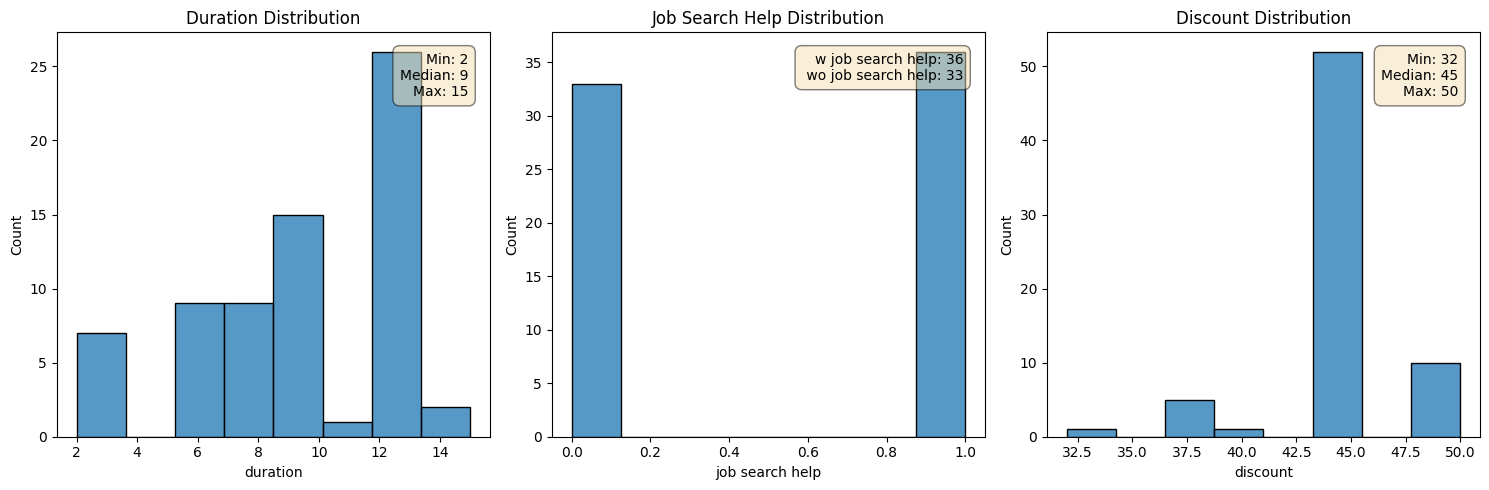

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Duration Distribution
sns.histplot(data=cources_df['duration'], ax=axes[0])
axes[0].set_title('Duration Distribution')
min_duration = cources_df['duration'].min()
median_duration = cources_df['duration'].median()
max_duration = cources_df['duration'].max()
axes[0].text(0.95, 0.95, f'Min: {min_duration:.0f}\nMedian: {median_duration:.0f}\nMax: {max_duration:.0f}',
             horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes,
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Job Search Help Distribution
sns.histplot(data=cources_df['job search help'].fillna(0), ax=axes[1])
axes[1].set_title('Job Search Help Distribution')
count_0 = len(cources_df[cources_df['job search help']!=1])
count_1 = len(cources_df[cources_df['job search help']==1])
axes[1].text(0.95, 0.95, f'w job search help: {count_1:.0f}\n wo job search help: {count_0:.0f}',
             horizontalalignment = 'right', verticalalignment = 'top', transform=axes[1].transAxes,
             bbox = dict(boxstyle = 'round,pad =0.5', fc = 'wheat', alpha = 0.5))


# Discount Distribution
sns.histplot(data=cources_df['discount'], ax=axes[2])
axes[2].set_title('Discount Distribution')
min_discount = cources_df['discount'].min()
median_discount = cources_df['discount'].median()
max_discount = cources_df['discount'].max()
axes[2].text(0.95, 0.95, f'Min: {min_discount:.0f}\nMedian: {median_discount:.0f}\nMax: {max_discount:.0f}',
             horizontalalignment='right', verticalalignment='top', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


plt.tight_layout()
plt.show()

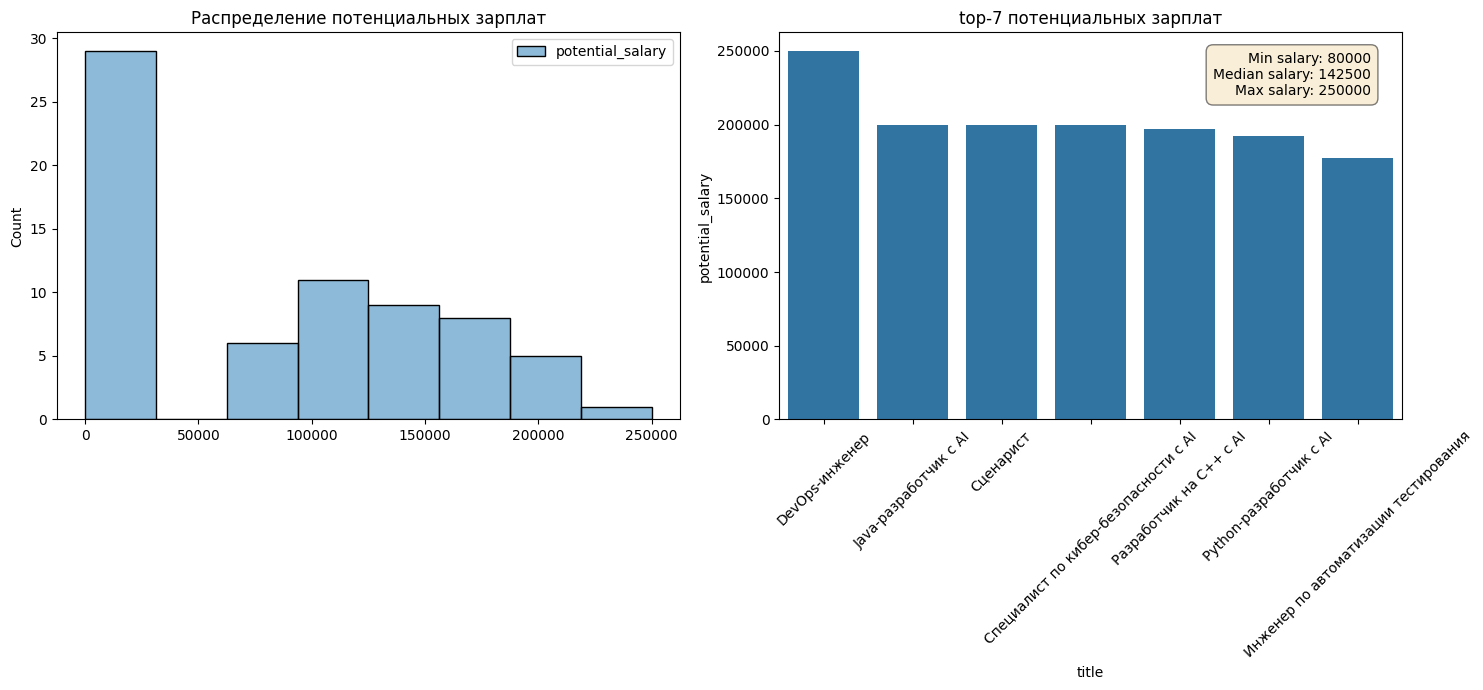

In [ ]:
fig, axis = plt.subplots(1,2, figsize = (15,7))

sns.histplot(cources_df[['title','potential_salary']], ax = axis[0])
axis[0].set_title("Распределение потенциальных зарплат")

sns.barplot(cources_df[['title','potential_salary']].set_index('title').nlargest(7, ['potential_salary']), x = 'title', y = 'potential_salary', ax = axis[1])
plt.xticks(rotation=45)
min_salary = cources_df[cources_df['potential_salary']>0]['potential_salary'].min()
median_salary = cources_df[cources_df['potential_salary']>0]['potential_salary'].median()
max_salary = cources_df['potential_salary'].max()
axis[1].text(0.95, 0.95, f'Min salary: {min_salary:.0f}\nMedian salary: {median_salary:.0f}\nMax salary: {max_salary:.0f}',
             horizontalalignment = 'right', verticalalignment = 'top', transform = axis[1].transAxes,
             bbox = dict(boxstyle = 'round,pad=0.5', fc= 'wheat', alpha = 0.5))

axis[1].set_title("top-7 потенциальных зарплат")

plt.tight_layout()
plt.show()

#### Опубликованные статьи

In [ ]:
posts_df['year'] = posts_df['date_adj'].dt.year

top7_posts_by_years = pd.merge(posts_df[posts_df['year']==2022].nlargest(7,['views']).reset_index()[['name', 'views']],
                               posts_df[posts_df['year']==2023].nlargest(7,['views']).reset_index()[['name', 'views']],
                               right_index = True,
                               left_index = True,
                               how = 'inner',
                               suffixes = ['_2022', '_2023'])
print("TOP-7 статей в 2022 и 2023 годах по количству просморов:")
print()
print("---------------------------------------------------------------------------------------------------------------")
top7_posts_by_years

TOP-7 статей в 2022 и 2023 годах по количству просморов:

---------------------------------------------------------------------------------------------------------------


,name_2022,views_2022,name_2023,views_2023
0,Направления развития современного образования,119768,Как устроены компьютерные вирусы,107481
1,Как создать NFT,100937,Как создать и продать свой NFT,105385
2,Профессиональная переподготовка,97986,Куда инвестору деть первый миллион прибыли,105325
3,Профессии с хорошей зарплатой: на кого лучше у...,90826,Как стать миллионером в 14 лет и потерять все ...,104068
4,Облачные технологии,88463,Как получить предложение работать в Apple,102809
5,Как подростки зарабатывают деньги в интернете,84020,Как выработать привычку не тратить все заработ...,93199
6,В чем суть Майнкрафта: свобода творчества и ра...,76467,Как из полицейского стать универсальным ИТ-сол...,89052


### Вывод
В результате выполнения практической работы были освоены продвинутые техники сбора данных путем парсинга HTML-страниц, их последующей консолидации из различных источников и проведения комплексного аналитического исследования для решения прикладных бизнес-задач.